# XGBoost manual scoring example

## Imports and setup

In [1]:
import xgboost as xgb
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
print(xgb.__version__)

1.7.4


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
seed = 42
test_size = 0.2

## Load and Split dataset

In [5]:
data = load_breast_cancer(as_frame=True)

In [6]:
X, y, feature_names = data.data, data.target, data.feature_names

In [7]:
X_trian, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

## Setup and train model

In [8]:
m1 = xgb.XGBClassifier()                                                  # default values from xgboost
m1.fit(X_trian, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [9]:
m2 = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=0.1)    # Smaller model to walkthrough
m2.fit(X_trian, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Explore smaller model's trees

Smaller Model - Tree 0


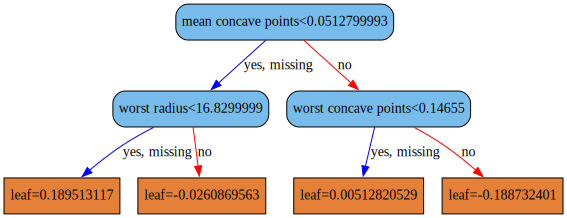

In [10]:
print("Smaller Model - Tree 0")
xgb.to_graphviz(m2, 
                condition_node_params={'shape': 'box', 'style': 'filled,rounded', 'fillcolor': '#78bceb'},
                leaf_node_params={'shape': 'box', 'style': 'filled', 'fillcolor': '#e48038'},
                yes_color='#0000FF', no_color='#FF0000'
               )

Smaller Model - Tree 1


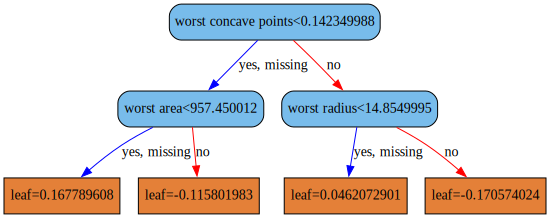

In [11]:
print("Smaller Model - Tree 1")
xgb.to_graphviz(m2, num_trees=1,
                condition_node_params={'shape': 'box', 'style': 'filled,rounded', 'fillcolor': '#78bceb'},
                leaf_node_params={'shape': 'box', 'style': 'filled', 'fillcolor': '#e48038'},
                yes_color='#0000FF', no_color='#FF0000'
               )

In [12]:
m2_table = m2.get_booster().trees_to_dataframe()
m2_table

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,mean concave points,0.051280,0-1,0-2,0-1,288.645782,113.750000,NaN
1,0,1,0-1,worst radius,16.830000,0-3,0-4,0-3,21.593933,70.500000,NaN
2,0,2,0-2,worst concave points,0.146550,0-5,0-6,0-5,26.538498,43.250000,NaN
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,0.189513,65.750000,NaN
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,-0.026087,4.750000,NaN
5,0,5,0-5,Leaf,NaN,NaN,NaN,NaN,0.005128,8.750000,NaN
6,0,6,0-6,Leaf,NaN,NaN,NaN,NaN,-0.188732,34.500000,NaN
7,1,0,1-0,worst concave points,0.142350,1-1,1-2,1-1,236.865540,112.856888,NaN
8,1,1,1-1,worst area,957.450012,1-3,1-4,1-3,42.357987,75.423508,NaN
9,1,2,1-2,worst radius,14.854999,1-5,1-6,1-5,11.567032,37.433380,NaN


In [13]:
# Manual Scoring from model as dataframe.
# Iterate over all trees starting from root node and add leaf scores

def score_manual(model, xtest):
    # get the model struct as dataframe
    table = model.get_booster().trees_to_dataframe()
    
    # pick the correct starting score
    if model.base_score:
        score = model.base_score
    else:
        score = 0
        
    # iterate over all trees
    for tree in table["Tree"].unique():
        string = f"{tree=} => "
        ID = f"{tree}-0"    # ID of root node of each tree is of form <tree_id>-0
        feature = ""

        # traverse tree till at leaf node
        while True:
            string += f"{ID} -> "
            row = table[(table["ID"] == ID)]
            feature = row["Feature"].values[0]
            if feature.startswith("Leaf"):
                leaf_value = row["Gain"].values[0]
                score += (leaf_value)
                print(f"[{score:.6f}]: {string} {leaf_value}")
                break
            else:
                tree = row["Tree"].values[0]
                threshold = row["Split"].values[0]
                ID = row["Yes"] if xtest[feature].iloc[0] < threshold else row["No"]
                ID = ID.values[0]
                
    print(f"[{score}]")
    return score

## Test scoring on a record

In [14]:
xtest = X_test.iloc[0:1].reset_index(drop=True)
xtest

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,12.47,18.6,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.1015,0.3014,0.0875


In [15]:
score = score_manual(m2, xtest)

[0.189513]: tree=0 => 0-0 -> 0-1 -> 0-3 ->  0.189513117
[0.357303]: tree=1 => 1-0 -> 1-1 -> 1-3 ->  0.167789608
[0.35730272500000004]


In [16]:
p = sigmoid(score)
(1 - p, p)

(0.4116126566132269, 0.5883873433867731)

In [17]:
model_predicted = m2.predict_proba(xtest)
model_predicted

array([[0.41161263, 0.58838737]], dtype=float32)

In [18]:
np.allclose((1-p, p), model_predicted)

True

## Try with larger model!

Larger Model - Tree 0


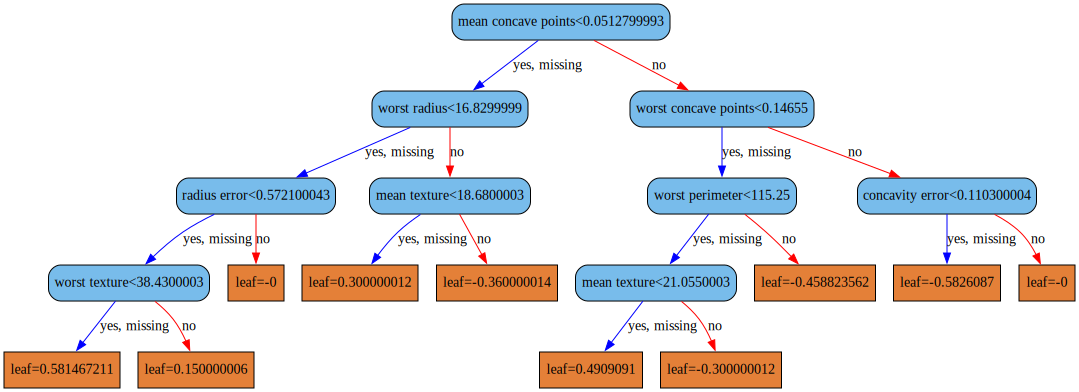

In [19]:
print("Larger Model - Tree 0")
xgb.to_graphviz(m1, num_trees=0,
                condition_node_params={'shape': 'box', 'style': 'filled,rounded', 'fillcolor': '#78bceb'},
                leaf_node_params={'shape': 'box', 'style': 'filled', 'fillcolor': '#e48038'},
                yes_color='#0000FF', no_color='#FF0000'
               )

In [20]:
m1score = score_manual(m1, xtest)
m1score

[0.581467]: tree=0 => 0-0 -> 0-1 -> 0-3 -> 0-7 -> 0-15 ->  0.581467211
[1.032373]: tree=1 => 1-0 -> 1-1 -> 1-3 -> 1-7 -> 1-15 ->  0.450906038
[1.433868]: tree=2 => 2-0 -> 2-1 -> 2-3 -> 2-7 -> 2-13 ->  0.401494473
[1.798324]: tree=3 => 3-0 -> 3-1 -> 3-3 -> 3-7 -> 3-11 ->  0.364456296
[2.140342]: tree=4 => 4-0 -> 4-1 -> 4-3 -> 4-7 -> 4-14 -> 4-17 ->  0.342018098
[2.464814]: tree=5 => 5-0 -> 5-1 -> 5-3 -> 5-7 -> 5-12 ->  0.32447201
[2.777417]: tree=6 => 6-0 -> 6-1 -> 6-3 -> 6-7 -> 6-16 -> 6-17 ->  0.31260246
[3.081277]: tree=7 => 7-0 -> 7-1 -> 7-3 -> 7-8 -> 7-13 ->  0.303860188
[3.375054]: tree=8 => 8-0 -> 8-1 -> 8-3 -> 8-7 -> 8-13 ->  0.293777257
[3.660898]: tree=9 => 9-0 -> 9-1 -> 9-3 -> 9-7 -> 9-11 ->  0.285844207
[3.409729]: tree=10 => 10-0 -> 10-2 -> 10-6 -> 10-10 -> 10-12 ->  -0.251169384
[3.676621]: tree=11 => 11-0 -> 11-1 -> 11-3 -> 11-5 -> 11-9 ->  0.266892046
[3.924838]: tree=12 => 12-0 -> 12-1 -> 12-3 -> 12-5 -> 12-9 ->  0.248216823
[4.164433]: tree=13 => 13-0 -> 13-1 -> 13-4 -

5.3475549331000005

In [21]:
m1p = sigmoid(m1score)

In [22]:
(1 - m1p, m1p)

(0.004737226619239032, 0.995262773380761)

In [23]:
m1_predicted = m1.predict_proba(xtest)
m1_predicted

array([[0.00473726, 0.99526274]], dtype=float32)

In [24]:
np.allclose((1 - m1p, m1p), m1_predicted)

True